Variational Autoencoder code from https://blog.keras.io/building-autoencoders-in-keras.html


*   Adapting sizes to fit time series
*   Commented on code to understand



In [ ]:
from google.colab import drive  
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import csv
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
path = "/content/drive/My Drive/Lightcurves_CSVUniformBin/"

all_points = []

for c in range(0, 500):
  points = []

  try:

    with open(path + "fig" + str(c) + ".csv", 'r') as file:

        read = csv.reader(file)
        read = list(read)
        x_data = read[0]
        y_data = read[1]
        for a in range(len(x_data)):
          x_data[a] = float(x_data[a])
          y_data[a] = float(y_data[a])

        if(len(x_data) == 301):
          
          x_data = np.divide(x_data, np.amax(x_data))

          y_data = pd.Series(y_data)
          y_data = y_data.interpolate() 
          y_data = np.array(y_data)

          for i in range(len(x_data)):
            points.append([x_data[i], y_data[i]])
          
          #used to be the following
          '''imp = SimpleImputer(missing_values=np.nan, strategy='mean')
          imp.fit(points)
          points = imp.transform(points)

          new_x_data = []
          new_y_data = []
          for item in points:
            new_x_data.append(item[0])
            new_y_data.append(item[1])

          new_y_data = np.array(new_y_data)

          all_points.append(new_y_data)'''

          all_points.append(y_data)

        else:
          print("Fig " + str(c) + " was not the required length; has length " + str(len(x_data)))

  except:
    print("An error occurred with fig", str(c))

An error occurred with fig 139
An error occurred with fig 142
An error occurred with fig 143
An error occurred with fig 144
An error occurred with fig 215
An error occurred with fig 252
An error occurred with fig 361
An error occurred with fig 458
An error occurred with fig 460
An error occurred with fig 477


In [ ]:
sequence = np.array(all_points)
print(sequence)
num_samples = len(sequence)
timesteps = len(sequence[0])

print(num_samples)
print(timesteps)
print(sequence.shape)

sequence = sequence.reshape(num_samples, timesteps)
print(sequence.shape)

[[0.92867328 0.97217974 0.93398217 ... 0.92474405 0.91618058 0.91618058]
 [0.9816004  0.97841091 0.97501565 ... 0.97877959 0.97334374 0.97452693]
 [0.86324818 0.84545057 0.87659408 ... 0.85977144 0.90338706 0.81964635]
 ...
 [0.45630678 0.61566887 0.42535297 ... 0.43395789 0.37802399 0.73053516]
 [0.50881037 0.31194642 0.49043848 ... 0.59574035 0.36999624 0.58539639]
 [0.77912399 0.63003795 0.71559314 ... 0.7499938  0.86124408 0.64782113]]
490
301
(490, 301)
(490, 301)


In [ ]:
original_dim = 301
intermediate_dim = 32
latent_dim = 2

inputs = keras.Input(shape=(original_dim,)) #input dimension: each lightcurve has 301 points
h = layers.Dense(intermediate_dim, activation='relu')(inputs) #densely connected neural network that maps to a vector of length 32
z_mean = layers.Dense(latent_dim)(h) #both lines map the previous layer to a 2-dimension layer
z_log_sigma = layers.Dense(latent_dim)(h)

#mean and log_sigma of the neurons in the latent space

In [ ]:
from keras import backend as K

def sampling(args): #creating a sampling function
    z_mean, z_log_sigma = args 
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1) #generating a random distribution given the parameters
    return z_mean + K.exp(z_log_sigma) * epsilon #mean + element-wise exponential

z = layers.Lambda(sampling)([z_mean, z_log_sigma]) #Lambda wraps arbitrary expressions as a layer
#uses the sampling function we just created and the arguments of z_mean and z_log_sigma from the layers before

In [ ]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder') #Model maps inputs to the three outputs here

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling') #passes in the z-sampling distribution from before
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs) #CAN CHANGE: .Dense to .Conv1D in both encoder and decoder
#using convolutions instead of a Dense neural network (have more power to encode better) 
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder') #maps the z-sampling to outputs of the original size of 301

# instantiate VAE model
outputs = decoder(encoder(inputs)[2]) #output is encoding the input and then decoding it again
vae = keras.Model(inputs, outputs, name='vae_mlp') #maps the original inputs to the encoded-then-decoded inputs

In [ ]:
#creating a custom loss function
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma) #kl_loss is regularizing the latent space
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [ ]:
vae.fit(sequence, sequence,
        epochs=300,
        batch_size=10)

Epoch 1/300
49/49 [==============================] - 2s 6ms/step - loss: 198.9412
Epoch 2/300
49/49 [==============================] - 0s 6ms/step - loss: 183.3464
Epoch 3/300
49/49 [==============================] - 0s 8ms/step - loss: 179.5742
Epoch 4/300
49/49 [==============================] - 0s 4ms/step - loss: 175.0275
Epoch 5/300
49/49 [==============================] - 0s 2ms/step - loss: 171.3123
Epoch 6/300
49/49 [==============================] - 0s 3ms/step - loss: 168.8370
Epoch 7/300
49/49 [==============================] - 0s 3ms/step - loss: 167.1528
Epoch 8/300
49/49 [==============================] - 0s 2ms/step - loss: 166.1997
Epoch 9/300
49/49 [==============================] - 0s 2ms/step - loss: 165.3224
Epoch 10/300
49/49 [==============================] - 0s 2ms/step - loss: 164.3822
Epoch 11/300
49/49 [==============================] - 0s 2ms/step - loss: 163.3783
Epoch 12/300
49/49 [==============================] - 0s 3ms/step - loss: 162.9019
Epoch 13/300


In [ ]:
#creating a test sequence

path = "/content/drive/My Drive/Lightcurves_CSVBinSizeNormal/"

all_predicted_points = []

for c in range(600, 610):
  points = []

  try:
    with open(path + "fig" + str(c) + ".csv", 'r') as file:
        read = csv.reader(file)
        read = list(read)
        x_data = read[0]
        y_data = read[1]
        for a in range(len(x_data)):
          x_data[a] = float(x_data[a])
          y_data[a] = float(y_data[a])

        if(len(x_data) == 301):
          
          x_data = np.divide(x_data, np.amax(x_data))

          y_data = pd.Series(y_data)
          y_data = y_data.interpolate() 
          y_data = np.array(y_data)

          for i in range(len(x_data)):
            points.append([x_data[i], y_data[i]])
          
          #used to be the following
          '''imp = SimpleImputer(missing_values=np.nan, strategy='mean')
          imp.fit(points)
          points = imp.transform(points)

          new_x_data = []
          new_y_data = []
          for item in points:
            new_x_data.append(item[0])
            new_y_data.append(item[1])

          new_y_data = np.array(new_y_data)

          all_predicted_points.append(new_y_data)'''

          all_predicted_points.append(y_data)

        else:
          print("Fig " + str(c) + " was not the required length; has length "+ str(len(x_data)))

  except:
    print("An error occurred with fig", str(c))

predicted_sequence = np.array(all_predicted_points)
num_samples = len(predicted_sequence)
timesteps = len(predicted_sequence[0])

print(num_samples)
print(timesteps)
print(predicted_sequence.shape)

predicted_sequence = predicted_sequence.reshape(num_samples, timesteps)
print(predicted_sequence.shape)

10
301
(10, 301)
(10, 301)


Predicted:


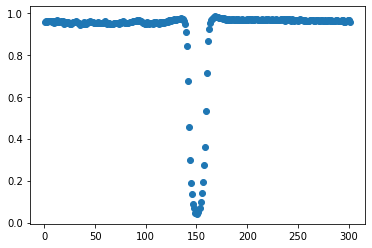

Actual:


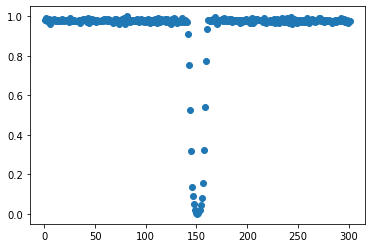

Predicted:


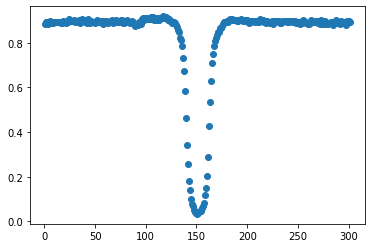

Actual:


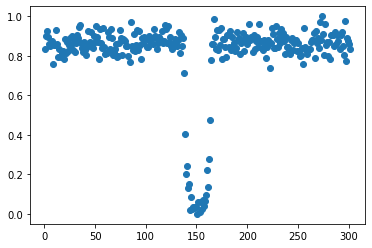

Predicted:


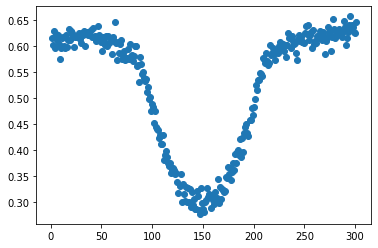

Actual:


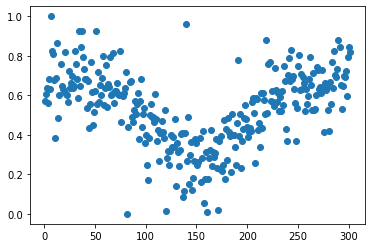

Predicted:


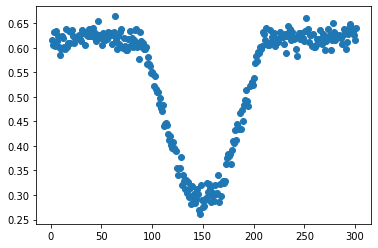

Actual:


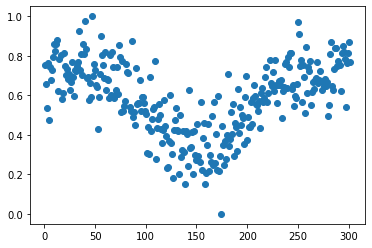

Predicted:


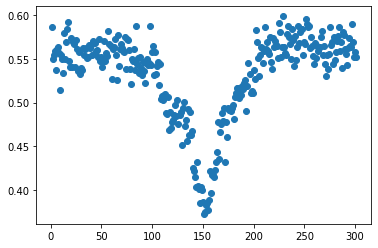

Actual:


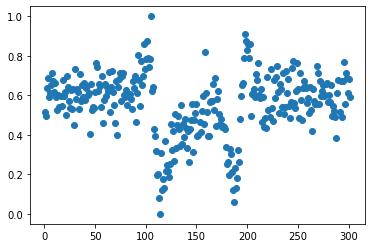

Predicted:


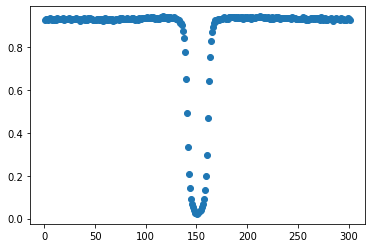

Actual:


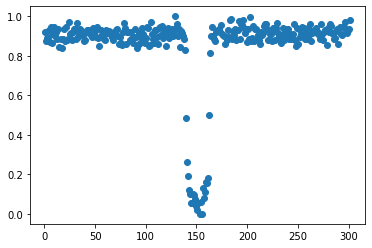

Predicted:


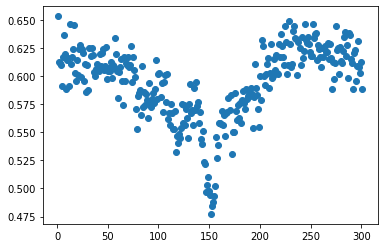

Actual:


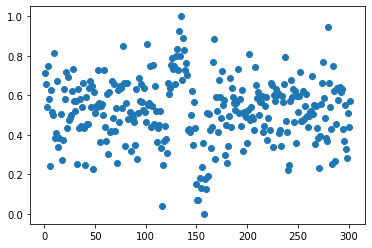

Predicted:


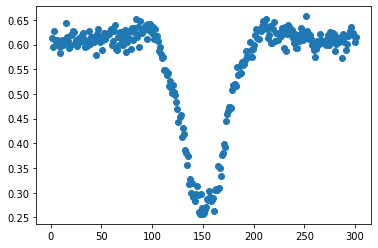

Actual:


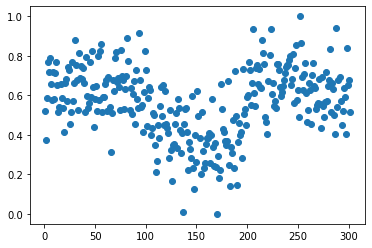

Predicted:


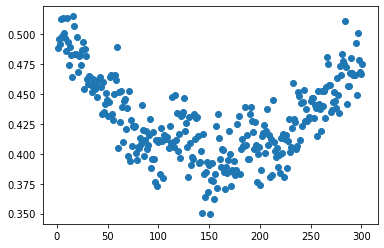

Actual:


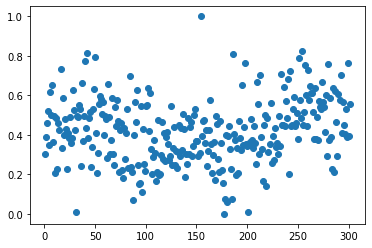

Predicted:


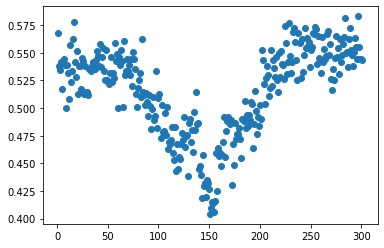

Actual:


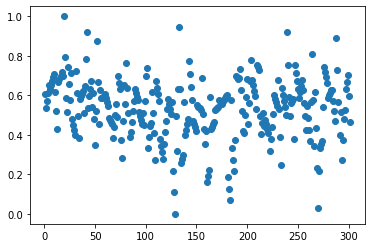

In [ ]:
prediction = vae.predict(predicted_sequence, verbose=0)

for j in range(len(prediction)):

  print("Predicted:")
  x_data = np.arange(start=1, stop=302)
  y_data = prediction[j]

  plot_points = []
  for i in range(len(x_data)):
      plot_points.append([x_data[i], y_data[i]])

  plot_points = np.array(plot_points)
  x, y = plot_points.T
  plt.scatter(x,y)
  plt.show()
  plt.close()

  print("Actual:")
  x_data = np.arange(start=1, stop=302)
  y_data = predicted_sequence[j]

  plot_points = []
  for i in range(len(x_data)):
      plot_points.append([x_data[i], y_data[i]])

  plot_points = np.array(plot_points)
  x, y = plot_points.T
  plt.scatter(x,y)
  plt.show()
  plt.close()